In [1]:
import IPython
from ipywidgets import Image
#
from Bio.PDB import PDBParser, PDBIO
#
import openmm as mm
import openmm.app as app
#
from openff.toolkit import ForceField, Molecule, Topology
from openff.units import Quantity, units
from openff.pablo import CCD_RESIDUE_DEFINITION_CACHE
from openff.pablo import ResidueDefinition
from openff.pablo.chem import PEPTIDE_BOND
from openff.pablo import topology_from_pdb
from openff.interchange import Interchange
from openff.interchange.components._packmol import (
    RHOMBIC_DODECAHEDRON,
    solvate_topology,
)
import sys
sys.path.append('..')
from ptm_prototype import draw_molecule
from ptm_prototype import react_mod
from ptm_prototype import parametrize_with_nagl
#
import rdkit
from rdkit import Chem
from rdkit import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.rdChemReactions import ReactionFromSmarts
from rdkit.Chem.rdchem import AtomPDBResidueInfo
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)
draw_options = Chem.Draw.MolDrawOptions()
draw_options.addAtomIndices = True
print(rdkit.__version__)

2025.03.6


clean raw crystal structure by bio.PDB, which remove redundant ANISOU lines, affording 9BFX_clean_biopdb.pdb

In [2]:
parser = PDBParser()
structure = parser.get_structure("9BFX_clean", "9BFX_clean.pdb")
io = PDBIO()
io.set_structure(structure)
io.save("9BFX_clean_biopdb.pdb")

1. use pymol to extract GNP, MG and (covalent ligand + CYS) to seperate file respectively (CYSLIG_clean.sdf, GNP_clean.pdb and MG.pdb), only keep protein structure (9BFX_clean_biopdb_protein_only.pdb)
2. use openmm-setup (in conda environment: openfe_env) to prepare protein with protonations, affording 9BFX_clean_biopdb_protein_only-processed.pdb
3. remove redundant morphic sidechain atoms from crystal fitted structure (e.g., ILE:142 C01...C05; ASP:154 N01/C01...C08), affording final_protein_only.pdb
4. delete covalent cys, affording final_protein_only_no_cys.pdb

prepare (ligand + cys) as non-caniconl amino acid (using CYSLIG_clean.sdf containg OXT and all hydrogen atoms, which need pymol to build them)

In [3]:
#use openff.pablo to generate non-canical amino acid topology
cysteine = CCD_RESIDUE_DEFINITION_CACHE["CYS"][0].to_openff_molecule()
Elironrasib = Molecule.from_smiles("C[C@H](OC)C(N=CC=C1)=[C@@]1[C@](N2CC)=C(CC(C)(C)COC([C@H]3NN(C([C@@H](NC([C@H](C(C)C)N(C(C4(F)CCN(C(C#CC(N(C)C)(C)C)=O)CC4)=O)C)=O)C[C@H]5CN6CCO5)=O)CCC3)=O)C7=C2C=CC6=C7")
Elironrasib.generate_unique_atom_names()
#rdkit SMARTS reaction to conjugate two motifs together, forming cis-configuration (consistent with crystal structure) 
covalent_triple_bond_smarts_cis = '[C:10]-[S:1]-[H:2].[C:11]-[C:3]#[C:4]-[C:5](=[O:6])-[N:7](-[C:8])-[C:9]>>[C:10]-[S:1]/[C:3](-[C:11])=[C:4](/[H])[C:5](=[O:6])-[N:7](-[C:8])-[C:9]'
rxn = ReactionFromSmarts(covalent_triple_bond_smarts_cis)
d2d = Draw.MolDraw2DCairo(800, 300)
d2d.DrawReaction(rxn, highlightByReactant=True)
Image(value=d2d.GetDrawingText())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x01,\x08\x02\x00\x00\x00\xb4O@m\x00\x00…

In [4]:
# The adduct of non-conical amino acid with random conformer generated for topology 
products = list(react_mod([cysteine, Elironrasib], covalent_triple_bond_smarts_cis))
adduct = products[0][0]
adduct

[15:56:13] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 


/home/haolan/anaconda3/envs/openff_ptm_prototype/lib/python3.11/site-packages/nglview/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


NGLWidget()

In [5]:
#check 2D structure with atom name, noticing a hydrogen name at conjugate side is missing, so we need to add its name manually
draw_molecule(
    adduct,
    width=1500,
    height=750,
    atom_notes={
        i: (
            f"{i}:{'|'.join([atom.name, *atom.metadata.get('synonyms', '').split()])}"
            + f"{'^' if bool(atom.metadata.get('leaving_atom')) else ''}"
        )
        for i, atom in enumerate(adduct.atoms)
    },
)
adduct.atom(5).name = 'H79x'

In [6]:
#add adduct as a non-canical amino acid into openff database
ligand_resdef = ResidueDefinition.from_molecule(
    molecule=adduct,
    residue_name="LIG",
    linking_bond=PEPTIDE_BOND,
)

In [7]:
#check extracted (ligand+cys) structure to have consistent 2D with just defined openff topology (by conical smiles) 
#load (ligand+cys) fragment extracted from pdb structure (rdkit read 3D sdf but ignore hydrogens, so we have to add them again) 
suppl = Chem.SDMolSupplier('CYSLIG_clean.sdf')[0]
suppl_H = Chem.AddHs(suppl, addCoords=True)
Elironrasib_ref_H_canonical_smiles = Chem.MolToSmiles(suppl_H, canonical=True)
print(Elironrasib_ref_H_canonical_smiles)
#convert openff topology to rdkit mol object for checking
adduct_mol_H = adduct.to_rdkit()
Elironrasib_top_H_canonical_smiles = Chem.MolToSmiles(adduct_mol_H, canonical=True)
print(Elironrasib_top_H_canonical_smiles)

[H]OC(=O)[C@@]([H])(N([H])[H])C([H])([H])S/C(=C(/[H])C(=O)N1C([H])([H])C([H])([H])C(F)(C(=O)N(C([H])([H])[H])[C@]([H])(C(=O)N([H])[C@]2([H])C(=O)N3N([H])[C@]([H])(C(=O)OC([H])([H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])c4c(-c5c([C@@]([H])(OC([H])([H])[H])C([H])([H])[H])nc([H])c([H])c5[H])n(C([H])([H])C([H])([H])[H])c5c([H])c([H])c(c([H])c45)N4C([H])([H])C([H])([H])O[C@]([H])(C4([H])[H])C2([H])[H])C([H])([H])C([H])([H])C3([H])[H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C1([H])[H])C(N(C([H])([H])[H])C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H]
[H]OC(=O)[C@@]([H])(N([H])[H])C([H])([H])S/C(=C(/[H])C(=O)N1C([H])([H])C([H])([H])C(F)(C(=O)N(C([H])([H])[H])[C@]([H])(C(=O)N([H])[C@]2([H])C(=O)N3N([H])[C@]([H])(C(=O)OC([H])([H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])C4=C(c5c([C@@]([H])(OC([H])([H])[H])C([H])([H])[H])nc([H])c([H])c5[H])N(C([H])([H])C([H])([H])[H])c5c([H])c([H])c(c([H])c54)N4C([H])([H])C([H])([H])O[C@]([H])(C4([H])[H])C2([H])[H])C([H])([H])C([H])([H])C3([H])[H])

In [8]:
#This step is to reorder atom index from extracted structure, making it consistent with openff topology 
list_1 = list(map(int, adduct_mol_H.GetProp("_smilesAtomOutputOrder")[1:-1].split(",")))
list_2 = list(map(int, suppl_H.GetProp("_smilesAtomOutputOrder")[1:-1].split(",")))
#
res = list(zip(list_2,list_1))
res.sort(key=lambda x: x[1])
unzipped_list_2, unzipped_list_1 = zip(*res)
new_indices = list(unzipped_list_2)
#
suppl_r = Chem.RenumberAtoms(suppl_H, new_indices)

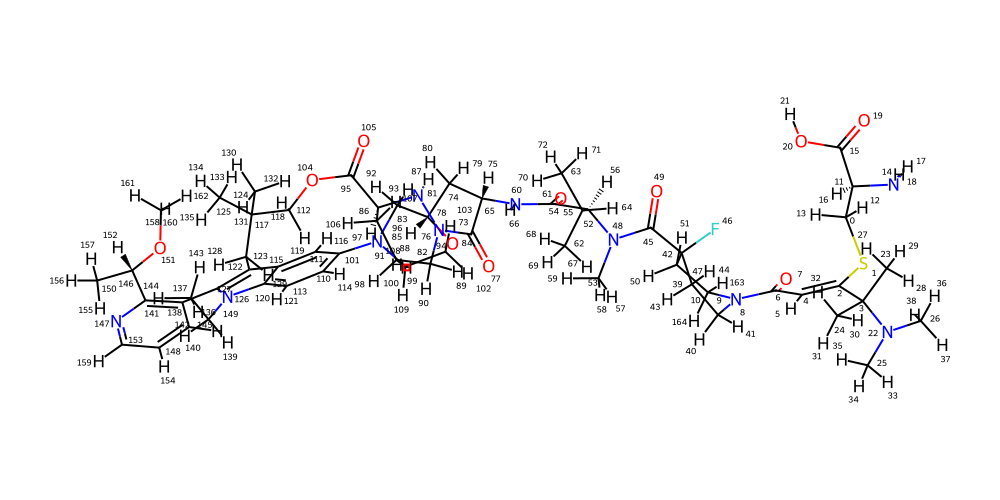

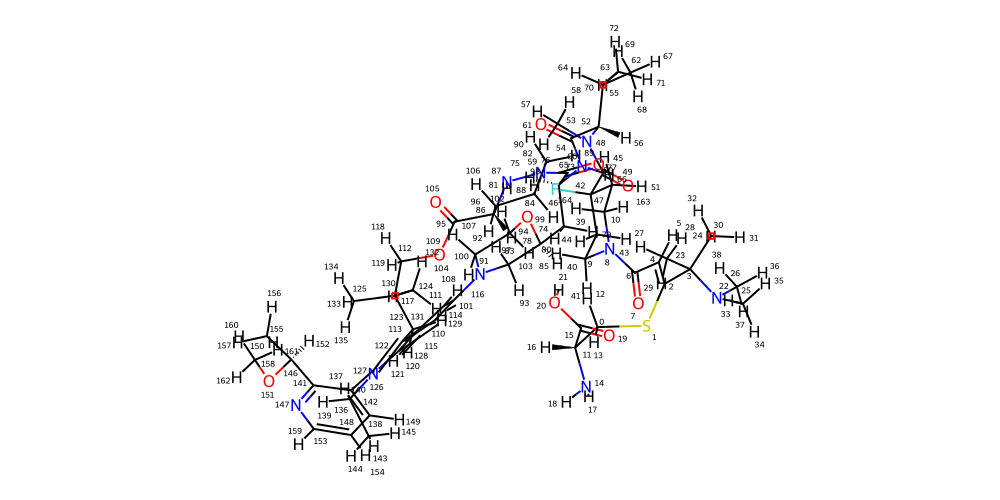

In [9]:
#double check in graph
IPython.display.display(Chem.Draw.MolToImage(adduct_mol_H, size=(1000, 500), options=draw_options))
IPython.display.display(Chem.Draw.MolToImage(suppl_r, size=(1000, 500), options=draw_options))

In [10]:
for i, atom in enumerate(adduct_mol_H.GetAtoms()):
    info = AtomPDBResidueInfo(
        atom.GetProp('_Name'),
        atom.GetIdx() + 1,
        ' ',
        'LIG',
        12,
        'B',
        ' ',
    )    
    suppl_r.GetAtomWithIdx(i).SetMonomerInfo(info)
Chem.MolToPDBFile(suppl_r, 'CYSLIG_clean_renamed.pdb')

insert lines of CYSLIG_clean_renamed.pdb into final_protein_only_no_cys.pdb (no_cys_CYSLIG_renamed.pdb), and remove atoms HXT, OXT and H2 atoms before pymol clean reindex (final_covalent.pdb).

In [11]:
#build off topology from pdb file
topology = topology_from_pdb(
    "final_covalent.pdb",
    residue_database=CCD_RESIDUE_DEFINITION_CACHE.with_({"LIG": [ligand_resdef]}),
)

In [12]:
#remove box_vectors
topology.box_vectors=None


In [13]:

rdmol = Chem.SDMolSupplier('GNP.sdf')[0]
Chem.SanitizeMol(rdmol)
GNP = Molecule.from_rdkit(rdmol, allow_undefined_stereo=True)
GNP.name = "GNP"
topology.add_molecule(GNP)
GNP

NGLWidget()

In [14]:
view = topology.visualize()
view.clear_representations()
view.add_representation("ball+stick", selection="all")
view

NGLWidget()

In [15]:
MG = Molecule.from_pdb_and_smiles('MG.pdb', '[Mg+2]')
topology.add_molecule(MG)


/home/haolan/anaconda3/envs/openff_ptm_prototype/lib/python3.11/site-packages/openff/toolkit/utils/base_wrapper.py:67: MoleculeDeprecationWarning: `Molecule.from_pdb_and_smiles` is deprecated in favor of `Topology.from_pdb`, the recommended method for loading PDB files. This method will be removed in a future release of the OpenFF Toolkit.
  value = func(*args, **kwargs)
/home/haolan/anaconda3/envs/openff_ptm_prototype/lib/python3.11/site-packages/openff/toolkit/topology/molecule.py:4795: UserWarning: `RDKitToolkitWrapper.from_polymer_pdb` is deprecated in favor of `Topology.from_pdb`, the recommended method for loading PDB files. (Note the `unique_molecules` argument.) This method will be removed in a future release of the OpenFF Toolkit.
  return toolkit.from_pdb_and_smiles(file_path, smiles, allow_undefined_stereo, _cls=cls, name=name)


3

In [16]:
view = topology.visualize()
view.clear_representations()
view.add_representation("ball+stick", selection="all")
view

NGLWidget()

In [17]:
topology.to_file('top.pdb')
#
solvated_topology = solvate_topology(
    topology,
    nacl_conc=Quantity(0.15, "mol/L"),
    padding=Quantity(1.0, "nm"),
    box_shape=RHOMBIC_DODECAHEDRON,
)
#
for molecule in solvated_topology.molecules:
    if molecule.hill_formula == "H2O":
        molecule.name = "HOH"
#
view = solvated_topology.visualize()
view.clear_representations()
view.add_representation("ball+stick", selection="all")
view

NGLWidget()

In [18]:
solvated_topology.to_file('solvated_top.pdb')

In [ ]:
force_field = ForceField("openff-2.2.1.offxml", "ff14sb_off_impropers_0.0.4.offxml", "tip3p.offxml")
interchange = force_field.create_interchange(solvated_topology)